In [1]:
import sys
sys.path.append("/Users/allisonmorgan/Code/src/github.com/allisonmorgan/")

In [2]:
from __future__ import division

from faculty_hiring.misc.util import *
from faculty_hiring.misc.plotting import *  # Definitions for LABEL_SIZE and such
from faculty_hiring.misc.gaussian_kde import gaussian_kde
from faculty_hiring.parse import faculty_parser, institution_parser
from faculty_hiring.parse import load
from faculty_hiring.parse.nces import parse_phds_awarded
from faculty_hiring.misc.subfield import topic_descriptions, longer_topic_descriptions, num_topics
from collections import Counter

%matplotlib inline

# File locations
faculty_file = '/Users/allisonmorgan/Documents/faculty_hiring/publication_data/current_data/faculty_cs_CURRENT.txt'
inst_file = '/Users/allisonmorgan/Documents/faculty_hiring/publication_data/current_data/inst_cs_CURRENT.txt'

# (Optional, these are for loading publication profiles)
dblp_dir = '/Users/allisonmorgan/Documents/faculty_hiring/publication_data/profiles_DBLP_Nov16/'

In [3]:
inst = institution_parser.parse_institution_records(open(inst_file, 'rU'))
asst_faculty = load.load_assistant_profs(open(faculty_file), inst, ranking='pi')
load.load_all_publications(asst_faculty, dblp_dir)

In [4]:
deep_learning_keywords = ["convolutional net", "convolutional neural net", "convolutional neural field", " rnn ", "deep learning", "deep-learning", "recursive neural net", "lstm", "long short-term memory", "generative adversarial network", "theano", "neural network", "deep belief net", "boltzmann machine", "convnet", "deep reinforcement learning", "deep neural network", " dnn ", " dnn-", "multilayer perceptron", "autoencoder", "auto-encoder", "activation function", "backprop", "back-prop", "ladder network", "bidirectional rnn", "bidirectional recurrent", "imagenet", "restricted boltzmann", "rmsprop", "convnet", "artificial neural network", "connectionist"]

Need to find all faculty members who have ever worked at an institution. Returns an array of faculty.

In [5]:
def faculty_at_institution(institution_name, asst_faculty):
    people = []
    for f in asst_faculty:
        for job in f.faculty:
            if job['rank'] != "PostDoc" and job['place'] == institution_name:
                people.append(f)
                break
                
    return people 

## General trend in deep-learning research

In [6]:
def distribution(asst_faculty, keywords):
    yearly_rate = Counter()
    for f in asst_faculty:
        if f.__contains__("dblp_pubs"):
            for pub in f.dblp_pubs:
                if any(pub['title'].lower().count(keyword) for keyword in keywords):
                    yearly_rate[pub['year']] += 1
                
    return yearly_rate 

dist = distribution(asst_faculty, deep_learning_keywords)

/anaconda2/lib/python2.7/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family [u'sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


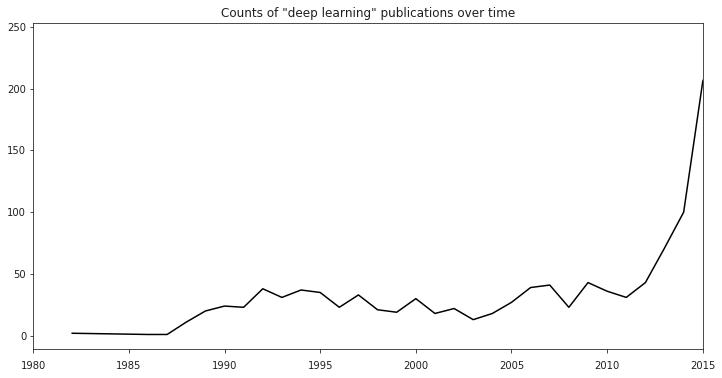

In [7]:
x = dict(dist).keys(); y = [];
for year, count in dict(dist).items():
    y.append(count)
    
plt.figure(figsize=(12,6))
plt.plot(x, y, color = 'k')
plt.xlim(1980, 2015)
plt.title('Counts of "deep learning" publications over time')
plt.show()

## Walk-through an example university

Let's try this procedure on University of Colorado, Boulder

In [8]:
place = 'University of Colorado, Boulder'

In [9]:
def get_hires_and_publications(place, keywords, asst_faculty):
    hires_and_publications = []
    for f in faculty_at_institution(place, asst_faculty):
        person = {"facultyName": f.facultyName, "phdRank": inst[f.phd()[0]]['pi'], "currentRank": inst[place]['pi']}

        person["start"] = 2020; person["end"] = 0;
        for job in f.faculty:
            if job['place'] == place and not (job['start_year'] is None):
                person["start"] = min(job['start_year'], person["start"])
                person["end"] = max(job['end_year'], person["end"])
    
        if person["end"] == 0:
            person["end"] = 2011
        if person["start"] == 2020:
            continue
    
        relevant_pubs = []
        if f.__contains__("dblp_pubs"):
            for pub in f.dblp_pubs:
                if any((pub['title'].lower().count(keyword) > 0) for keyword in keywords): #or relevant_venue:
                    #print(pub['title'])
                    relevant_pubs.append(pub['year'])
                        
        person["pubs"] = relevant_pubs
        person["phd_location"] = f.phd_location
        person["faculty_record"]= f
    
        hires_and_publications.append(person)
    
    return hires_and_publications

Let's plot the above data so we can better see when hires and publications occurred.

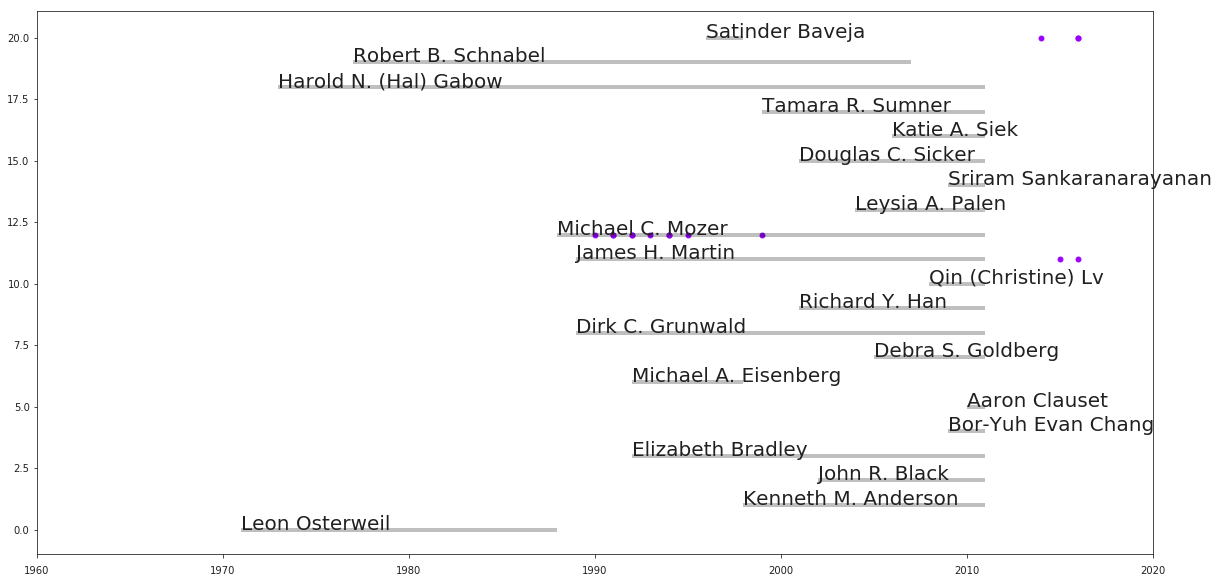

In [10]:
def plot_careers(place, keywords, asst_faculty):
    i = 0
    plt.figure(figsize=(20,10))
    for person in get_hires_and_publications(place, keywords, asst_faculty):
        #print person['facultyName']
        plt.plot([person["start"], person["end"]], [i, i], linewidth= 4, color = 'k', alpha = .25)
        plt.text(person["start"], i, person["facultyName"], fontsize=20)
    
        if len(person['pubs']) > 0:
            plt.scatter(person['pubs'], [i]*len(person['pubs']), s = 24, color = [153.0/255.0, 0.0/255.0, 255.0/255.0])
        i += 1

    plt.xlim(1960, 2020)

plot_careers(place, deep_learning_keywords, asst_faculty)

Did the first deep-learning publication coincide with a faculty hiring event? Is the date of publication within two years of the author's hire? 

In [11]:
def find_infected_hire(place, keywords, asst_faculty):
    '''
    Returns None if no infected hire found, otherwise the first hire
    is returned as (person, year of infectious publication).
    '''
    candidates = []
    for person in get_hires_and_publications(place, keywords, asst_faculty):
        person_pubs = person["pubs"]
        # If we do not know the faculty member's start date, or they have no pubs
        if not person["start"] or len(person_pubs) == 0:
            continue
        
        # Consider the publications when the entry was a professor at the institution
        person_pubs = filter(lambda x: person["start"] <= x <= person["end"], person_pubs)
        if person_pubs:
            candidates.append((person, person_pubs))
    
    # If the university was never "infected"
    if not candidates:
        return None
    else:
        return min(candidates, key=lambda xs: min(xs[1]))
        
print "\nWas a \"deep-learning\" researcher hired who might have led to the research area? {0}".format(find_infected_hire(place, deep_learning_keywords, asst_faculty))


Was a "deep-learning" researcher hired who might have led to the research area? ({'faculty_record': <faculty_hiring.parse.faculty_parser.faculty_record instance at 0x10f542fc8>, 'end': 2011, 'currentRank': 68.17, 'pubs': [1999, 1995, 1994, 1994, 1993, 1992, 1992, 1991, 1991, 1990], 'start': 1988, 'phd_location': 'UC San Diego', 'phdRank': 27.93, 'facultyName': 'Michael C. Mozer'}, [1999, 1995, 1994, 1994, 1993, 1992, 1992, 1991, 1991, 1990])


In [12]:
def is_infected_hire(person, delta_t):
    return any([(pub - person[0]["start"]) <= delta_t for pub in person[0]["pubs"]])

In [13]:
print "Was the person who infected CU Boulder (Mike Mozer), infected by hiring? {0}".format(is_infected_hire(find_infected_hire(place, deep_learning_keywords, asst_faculty), 2))

Was the person who infected CU Boulder (Mike Mozer), infected by hiring? True


## For all universities

In [14]:
def percent_has_relevant_prior_pubs(delta_t, keywords, asst_faculty):
    n_no_priors = 0
    n_yes_priors = 0
    total = 0
    # Go through every institution
    for place in inst.keys():
        if place == "UNKNOWN" or place == "All others":
            continue
            
        # Look for the faculty member which has infected the institution 
        infected_hire = find_infected_hire(place, keywords, asst_faculty)
        if not infected_hire:
            continue
        
        # Were they publishing on deep-learning before their hire date?
        if is_infected_hire(infected_hire, delta_t):
            n_yes_priors += 1
        else:
            n_no_priors += 1
        total += 1
    
    print("Hires with no background in topic: {0}, Hires with background in topic: {1}, Total infected univesities: {2}".format(n_no_priors, n_yes_priors, total))
    return (float(n_no_priors)/total, float(n_yes_priors)/total)

In [15]:
topic_modeling_keywords = ["probabilistic latent semantic analysis", "plsa", "latent dirichlet allocation","latent semantic analysis", "latent semantic indexing", "topic model", "probabilistic topic modeling"]
incremental_keywords = ["incremental computation", "self-adjusting computation", "program derivative","dbtoaster", "incremental view", "partial evaluation", "incremental computing", "incrementally compute", "frtime", "adaptive functional programming", "delta ml", "haskell adaptive", "cornell synthesizer generator", "icedust", "adapton", "one-way dataflow constraints", "reactive computation", "differential dataflow", "jane street incremental", "incremental datalog", "incremental prolog", "incremental type checking", "self-adjusting"]
deep_learning_keywords = ["convolutional net", "convolutional neural net", "convolutional neural field", " rnn ", "deep learning", "deep-learning", "recursive neural net", "lstm", "long short-term memory", "generative adversarial network", "theano", "neural network", "deep belief net", "boltzmann machine", "convnet", "deep reinforcement learning", "deep neural network", " dnn ", " dnn-", "multilayer perceptron", "autoencoder", "auto-encoder", "activation function", "backprop", "back-prop", "ladder network", "bidirectional rnn", "bidirectional recurrent", "imagenet", "restricted boltzmann", "rmsprop", "convnet", "artificial neural network", "connectionist"]

print(">>> Deep Learning (n_keywords: {0})".format(len(deep_learning_keywords)))
(prob_no_priors, prob_yes_priors) = percent_has_relevant_prior_pubs(2, deep_learning_keywords, asst_faculty)
print("Fraction of infections due to hiring: {0}, not due to hiring: {1}\n".format(prob_yes_priors, prob_no_priors))
print(">>> Topic Modeling (n_keywords: {0})".format(len(topic_modeling_keywords)))
(prob_no_priors, prob_yes_priors) = percent_has_relevant_prior_pubs(2, topic_modeling_keywords, asst_faculty)
print("Fraction of infections due to hiring: {0}, not due to hiring: {1}\n".format(prob_yes_priors, prob_no_priors))
print(">>> Incremental Computation (n_keywords: {0})".format(len(incremental_keywords)))
(prob_no_priors, prob_yes_priors) = percent_has_relevant_prior_pubs(2, incremental_keywords, asst_faculty)
print("Fraction of infections due to hiring: {0}, not due to hiring: {1}".format(prob_yes_priors, prob_no_priors))

>>> Deep Learning (n_keywords: 34)
Hires with no background in topic: 79, Hires with background in topic: 40, Total infected univesities: 119
Fraction of infections due to hiring: 0.336134453782, not due to hiring: 0.663865546218

>>> Topic Modeling (n_keywords: 7)
Hires with no background in topic: 29, Hires with background in topic: 14, Total infected univesities: 43
Fraction of infections due to hiring: 0.325581395349, not due to hiring: 0.674418604651

>>> Incremental Computation (n_keywords: 23)
Hires with no background in topic: 17, Hires with background in topic: 11, Total infected univesities: 28
Fraction of infections due to hiring: 0.392857142857, not due to hiring: 0.607142857143


In [16]:
def percent_has_prestige(delta_t, keywords, asst_faculty):
    n_came_from_prestige = 0
    n_moved_to_prestige = 0
    total = 0
    # Go through every institution
    for place in inst.keys():
        if place == "UNKNOWN" or place == "All others":
            continue
            
        # Look for the faculty member which has infected the institution 
        infected_hire = find_infected_hire(place, keywords, asst_faculty)
        if not infected_hire:
            continue
        
        # If the transmission was via hiring, did they come from a more prestigious 
        # university than they are currently employed?
        if is_infected_hire(infected_hire, delta_t):
            if infected_hire[0]['phdRank'] < infected_hire[0]['currentRank']:
                n_came_from_prestige += 1
            else:
                n_moved_to_prestige += 1
            total += 1
    
    print("Hires who came from more prestigious background: {0}, came from less prestigious background: {1}, total: {2}".format(n_came_from_prestige, n_moved_to_prestige, total))
    return (float(n_came_from_prestige)/total, float(n_moved_to_prestige)/total)

In [17]:
print(">>> Deep Learning (n_keywords: {0})".format(len(deep_learning_keywords)))
(prob_came_from_prestige, prob_moved_to_prestige) = percent_has_prestige(2, deep_learning_keywords, asst_faculty)
print ""
print(">>> Topic Modeling (n_keywords: {0})".format(len(topic_modeling_keywords)))
(prob_came_from_prestige, prob_moved_to_prestige) = percent_has_prestige(2, topic_modeling_keywords, asst_faculty)
print ""
print(">>> Incremental Computation (n_keywords: {0})".format(len(incremental_keywords)))
(prob_came_from_prestige, prob_moved_to_prestige) = percent_has_prestige(2, incremental_keywords, asst_faculty)
print ""

>>> Deep Learning (n_keywords: 34)
Hires who came from more prestigious background: 33, came from less prestigious background: 7, total: 40

>>> Topic Modeling (n_keywords: 7)
Hires who came from more prestigious background: 11, came from less prestigious background: 3, total: 14

>>> Incremental Computation (n_keywords: 23)
Hires who came from more prestigious background: 9, came from less prestigious background: 2, total: 11



## Null Model

In [18]:
import copy
import random

asst_faculty_shuffled = copy.deepcopy(asst_faculty)
all_titles = []

for f in asst_faculty:
    if f.__contains__("dblp_pubs"):
        for pub in f.dblp_pubs:
            all_titles.append(pub['title'])

Generate our null model by shuffling the list of publications, and assigning them to faculty at random.

In [19]:
shuffled = copy.copy(all_titles)
fraction_dist = []
for i in range(25):
    random.shuffle(shuffled)
    for f in asst_faculty_shuffled:
        if f.__contains__("dblp_pubs"):
            for pub in f.dblp_pubs:
                pub['title'] = shuffled.pop()
    
    (prob_no_priors, prob_yes_priors) = percent_has_relevant_prior_pubs(2, incremental_keywords, asst_faculty_shuffled)
    print("Fraction of infections due to hiring: {0}, not due to hiring: {1}".format(prob_yes_priors, prob_no_priors))
    fraction_dist.append(prob_yes_priors)
    shuffled = copy.copy(all_titles)

Hires with no background in topic: 33, Hires with background in topic: 7, Total infected univesities: 40
Fraction of infections due to hiring: 0.175, not due to hiring: 0.825
Hires with no background in topic: 35, Hires with background in topic: 8, Total infected univesities: 43
Fraction of infections due to hiring: 0.186046511628, not due to hiring: 0.813953488372
Hires with no background in topic: 25, Hires with background in topic: 11, Total infected univesities: 36
Fraction of infections due to hiring: 0.305555555556, not due to hiring: 0.694444444444
Hires with no background in topic: 39, Hires with background in topic: 5, Total infected univesities: 44
Fraction of infections due to hiring: 0.113636363636, not due to hiring: 0.886363636364
Hires with no background in topic: 36, Hires with background in topic: 8, Total infected univesities: 44
Fraction of infections due to hiring: 0.181818181818, not due to hiring: 0.818181818182
Hires with no background in topic: 41, Hires with ba

(array([ 6.91764706,  0.        ,  1.72941176,  6.91764706,  6.91764706,
         8.64705882,  5.18823529,  1.72941176,  3.45882353,  1.72941176]),
 array([ 0.10204082,  0.12517007,  0.14829932,  0.17142857,  0.19455782,
         0.21768707,  0.24081633,  0.26394558,  0.28707483,  0.31020408,
         0.33333333]),
 <a list of 10 Patch objects>)

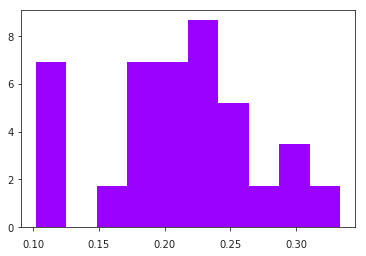

In [20]:
plt.hist(fraction_dist, normed=True, color=[153.0/255.0, 0.0/255.0, 255.0/255.0])

In [21]:
print "How many simulations resulting in a higher infection rate due to hiring? {0}".format((len([x for x in fraction_dist if x >= (0.392857142857)]) + 1)/(len(fraction_dist) + 1))

How many simulations resulting in a higher infection rate due to hiring? 0.0384615384615


## Load Cached Simulations of Null Model

The above simulation was run 10,000 times to generate the three pickles in this folder: `deep_learning.p`, `incremental.p`, and `topic_modeling.p`. 

Let's load them in here. First, checking "incremental computation":

In [22]:
import cPickle
with open("/Users/allisonmorgan/Code/src/github.com/allisonmorgan/epistemic_inequality/publications/incremental.p", "rb") as input_file:
    x = cPickle.load(input_file)

In [23]:
print("How many simulations have been run? {0}".format(len(x)))

How many simulations have been run? 10000


In [24]:
real_infection_rate = 0.392857142857 # From "For all universities" section above
print("What is the average infection due to hiring under model? {0}".format(sum(x)/len(x)))
print("How many simulations resulting in a higher infection rate due to hiring? {0}".format((len([i for i in x if i >= real_infection_rate]) + 1)/(len(x) + 1)))

What is the average infection due to hiring under model? 0.193805365345
How many simulations resulting in a higher infection rate due to hiring? 0.001099890011


Next, checking "topic modeling":

In [25]:
with open("/Users/allisonmorgan/Code/src/github.com/allisonmorgan/epistemic_inequality/publications/topic_modeling.p", "rb") as input_file:
    x = cPickle.load(input_file)

In [26]:
print("How many simulations have been run? {0}".format(len(x)))

How many simulations have been run? 10000


In [27]:
real_infection_rate = 0.325581395349 # From "For all universities" section above
print("What is the average infection due to hiring under model? {0}".format(sum(x)/len(x)))
print("How many simulations resulting in a higher infection rate due to hiring? {0}".format((len([i for i in x if i >= real_infection_rate]) + 1)/(len(x) + 1)))

What is the average infection due to hiring under model? 0.224871459028
How many simulations resulting in a higher infection rate due to hiring? 0.010398960104


Finally, check "deep learning":

In [28]:
with open("/Users/allisonmorgan/Code/src/github.com/allisonmorgan/epistemic_inequality/publications/deep_learning.p", "rb") as input_file:
    x = cPickle.load(input_file)

In [29]:
print("How many simulations have been run? {0}".format(len(x)))

How many simulations have been run? 10000


In [30]:
real_infection_rate = 0.336134453782 # From "For all universities" section above
print("What is the average infection due to hiring under model? {0}".format(sum(x)/len(x)))
print("How many simulations resulting in a higher infection rate due to hiring? {0}".format((len([i for i in x if i >= real_infection_rate]) + 1)/(len(x) + 1)))

What is the average infection due to hiring under model? 0.302162023439
How many simulations resulting in a higher infection rate due to hiring? 0.166583341666


## Transmission diagrams

In [31]:
import matplotlib.patches as patches
style = "Simple,tail_width=0.5,head_width=7,head_length=8"
ACCENT_COLOR_1 = np.array([127, 37, 251]) / 255.
kw = dict(arrowstyle=style)

def get_infection_timeline(keywords):
    
    infection_timeline = {}

    for place in inst:
        year = np.inf  # Initialize to inf (never infected)
        hiring_inf = None
        person = None

        # Get person with first relevant publication 
        first_infected = find_infected_hire(place, keywords, asst_faculty)
        if first_infected is not None:
            if is_infected_hire(first_infected, 2):
                year = first_infected[0]["start"]
                hiring_inf = first_infected[0]["phd_location"]
                person = first_infected[0]
            else:
                year = np.min(first_infected[1])
                
        # year of infection, infecting dept (if caused by hiring, else None), person
        infection_timeline[place] = (year, hiring_inf, person)
        
    return infection_timeline

# Build timelines
deep_learning_timeline = get_infection_timeline(deep_learning_keywords)
topic_modeling_timeline = get_infection_timeline(topic_modeling_keywords)
incremental_timeline = get_infection_timeline(incremental_keywords)

'''
Examples: 
print(deep_learning_timeline["MIT"])  # Year when MIT was infected and by whom.
print(deep_learning_timeline["UCLA"]) # UCLA was a spontaneous infection.
print(deep_learning_timeline["University of Nebraska, Lincoln"])  # UNL hasn't a deep learner. 

Outputs:
(1988, 'UC San Diego', {'faculty_record': <faculty_hiring.parse.faculty_parser.faculty_record instance at 0x110e26dd0>, 'end': 1998, 'pubs': [2016, 2015, 2015, 2013, 2000, 1998, 1997, 1996, 1993, 1993, 1991, 1990], 'start': 1988, 'phd_location': 'UC San Diego', 'facultyName': 'Michael Jordan'})
(1993, None, None)
(inf, None, None)
'''

def make_year_snapshot(ax, timeline, limit=206, year=2000, prev_year=-np.inf, verbose=False, name=None):
    ax.set_aspect(1)
    sel_places = [p[1] for p in sorted([(inst[place]['pi'], place) for place in inst])][:limit]
    deg_places = np.pi/2 - np.linspace(0, 2*np.pi, limit, endpoint=False)
    r = 1
    x = r*np.cos(deg_places)
    y = r*np.sin(deg_places)
    r2 = 0.955
    x2 = r2*np.cos(deg_places)
    y2 = r2*np.sin(deg_places)
    ax.scatter(x, y, edgecolor='None', color=LIGHT_COLOR, s=5)
    arrows = []
    new_infections = 0
    new_spotaneous = 0
    
    for i, place in enumerate(sel_places): 
        if timeline[place][0] < year:
            if timeline[place][1] is None:
                if timeline[place][0] >= prev_year:
                    new_spotaneous += 1
                edgecolor = DARK_COLOR
                color = 'w'
                s = 50
            else:
                color = ACCENT_COLOR_1
                edgecolor = 'w'
                s = 100
                if timeline[place][1] in sel_places and timeline[place][0] >= prev_year:
                    new_infections += 1
                    if verbose: print(timeline[place][1])
                    org = sel_places.index(timeline[place][1])
                    
                    #radius = .8 - (np.abs(deg_places[org]-deg_places[i]) / (np.pi))
                    radius = -np.log((0.01+np.abs(deg_places[org]-deg_places[i]) / (np.pi)))
                    p1 = (x[org],y[org])
                    p2 = (x2[i],y2[i])
                    
                    if deg_places[i] > deg_places[org] and deg_places[i] - deg_places[org] < .9*np.pi: 
                        radius *= -1
                        arrows.append(patches.FancyArrowPatch(p1, p2, zorder=-10, 
                            connectionstyle="arc3,rad=%f" % (radius), color='k', **kw))
                    else:
                        arrows.append(patches.FancyArrowPatch(p1, p2, zorder=-10, 
                            connectionstyle="arc3,rad=%f" % (radius), color='k', **kw))
                     
            ax.scatter(x[i], y[i], edgecolor=edgecolor, color=color, s=s)
            
    for a in arrows:
        ax.add_patch(a)
        
    ax.axis('off')
    
    opts = {'y':0.975, 'fontsize':LABEL_SIZE+2}
    
    if prev_year > -np.inf:
        ax.set_title('%d to %d' % (int(prev_year), int(year)-1), **opts)
    else:
        ax.set_title('Up to %d' % (int(year)), **opts)
        
    xnudge = .075
    xloc=1.125
    ax.scatter(xloc, -.75, edgecolor='w', color=ACCENT_COLOR_1, s=100)    
    ax.text(xloc-xnudge, -.75, "+%d" % new_infections, color=ACCENT_COLOR_1, fontsize=LABEL_SIZE+1, ha='right', va='center')
    
    ax.scatter(xloc, -.925, color='w', edgecolor=DARK_COLOR, s=50)    
    ax.text(xloc-xnudge, -.925, "+%d" % new_spotaneous, color=DARK_COLOR, fontsize=LABEL_SIZE+1, ha='right', va='center')
        
    if name is not None:
        ax.text(-r*1.25, 0, name, rotation=90, fontsize=LABEL_SIZE+4, ha='center', va='center', rotation_mode='anchor')

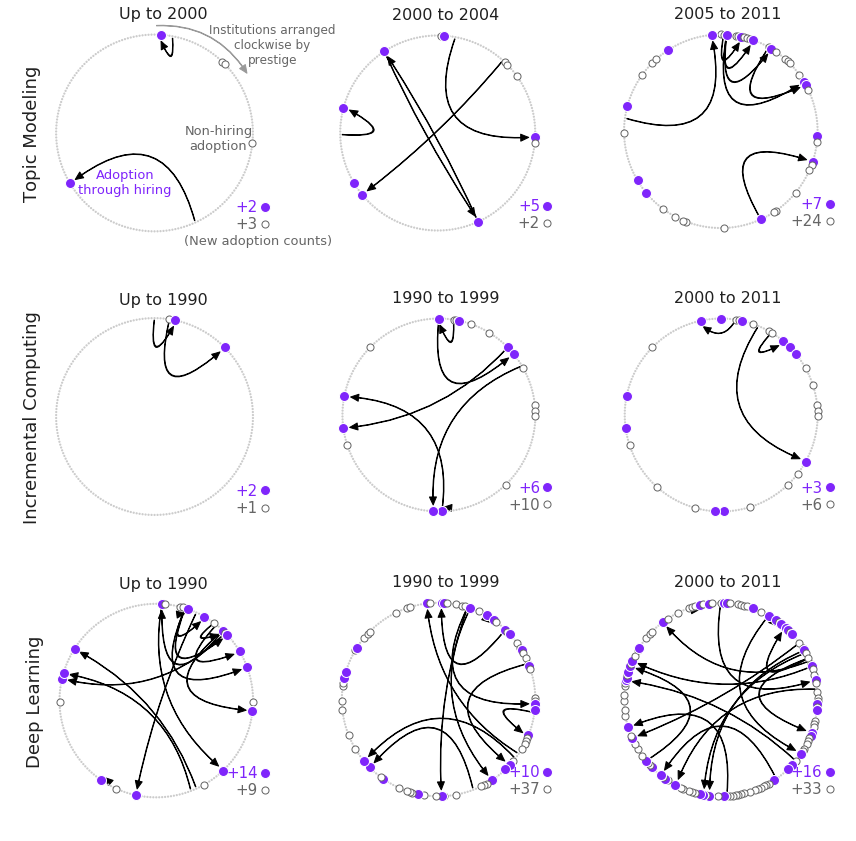

In [32]:
fig, ax_grid = plt.subplots(3,3,figsize=(12,12))

times = [("Topic Modeling", topic_modeling_timeline), 
         ("Incremental Computing", incremental_timeline), 
         ("Deep Learning", deep_learning_timeline)]

years = [[2000, 2005, 2012],
         [1990, 2000, 2012],
         [1990, 2000, 2012],]

for j, axs in enumerate(ax_grid):
    title, timeline = times[j]
    for i, year in enumerate(years[j]):
        if i == 0:
            prev_year = -np.inf
            label = title
        else:
            prev_year = years[j][i-1]
            label = None
            
        make_year_snapshot(axs[i], timeline, year=year, prev_year=prev_year, name=label)
        
ax_grid[0][0].text(-0.3, -.5, 'Adoption\nthrough hiring', ha='center', va='center', fontsize=LABEL_SIZE-1, color=ACCENT_COLOR_1)
ax_grid[0][0].text(0.65, -.05, 'Non-hiring\nadoption', ha='center', va='center', fontsize=LABEL_SIZE-1, color=DARK_COLOR)
ax_grid[0][0].text(1.05, -1.1, '(New adoption counts)', ha='center', va='center', fontsize=LABEL_SIZE-1, color=DARK_COLOR)

yn = 0.01
ax_grid[0][0].add_patch(patches.FancyArrowPatch((0, 1.1-yn), (.95,.6-yn), zorder=-10,
                            connectionstyle="arc3,rad=-.3", color='0.6', **kw))
ax_grid[0][0].text(1.2, .9, 'Institutions arranged\nclockwise by\nprestige', ha='center', va='center', fontsize=LABEL_SIZE-2, color=DARK_COLOR)

    
plt.tight_layout()
plt.savefig('../results/timelines.pdf')
plt.show()